# Grid Intensity Forecasting

In [57]:
import gridemissions as ge
from power_dashboard.gridemissions_utils import load_bulk
import pandas as pd
from pathlib import Path
from typing import Union, List, Tuple
import matplotlib.pyplot as plt
from datetime import datetime
from functools import partial
import numpy as np
from time import time

##  Extract and transform gridemissions historical time series

In [2]:
co2i = load_bulk("../data/interim/gridemissions", "co2i")

Reshape into a long format with three columns.

In [3]:
all_ts = co2i.df.reset_index().melt(id_vars=['period'], var_name="region", value_name="CO2 Intensity").dropna()

In [6]:
# period represents "UTC Time at End of Hour" (see https://github.com/jdechalendar/gridemissions/blob/696838bc82c74aa40ab54206b36aec2026908a2d/src/gridemissions/eia_bulk_grid_monitor.py#L29)
# We need to localize the timestamp and subtract an hour to get to the beginning of the hour.
all_ts.period = all_ts.period.dt.tz_localize('UTC') - pd.Timedelta(hours=1)

In [108]:
all_ts.period.min(), all_ts.period.max()

(Timestamp('2018-07-01 04:00:00+0000', tz='UTC'),
 Timestamp('2024-06-15 06:00:00+0000', tz='UTC'))

In [109]:
recent_all_ts = pd.read_csv("../data/raw/recent_grid_emissions.csv", index_col=0, parse_dates=True)

In [111]:
recent_all_ts.index.min(), recent_all_ts.index.max()

(Timestamp('2024-07-07 21:00:00'), Timestamp('2024-07-21 20:00:00'))

Select the time-series for the ISNE region

In [7]:
df = all_ts.loc[all_ts['region'] == 'CO2i_ISNE_D'].dropna()
df.tail()

,period,region,CO2 Intensity
1514578,2024-06-15 02:00:00+00:00,CO2i_ISNE_D,290.016321
1514579,2024-06-15 03:00:00+00:00,CO2i_ISNE_D,283.324206
1514580,2024-06-15 04:00:00+00:00,CO2i_ISNE_D,291.796152
1514581,2024-06-15 05:00:00+00:00,CO2i_ISNE_D,285.924739
1514582,2024-06-15 06:00:00+00:00,CO2i_ISNE_D,277.681349


In [8]:

df["local_time"] = df.period.dt.tz_convert('America/New_York')

### Evaluate the "best hours" of the day to charge.

Find the empirical 4-hour window of minimum grid intensity daily over the history, and evaluate how consistent the timing it is.  If it's almost always at the same time of day, a forecast is less important.

In [9]:
df["rolling_avg_intensity"] = df["CO2 Intensity"].rolling(window=4).mean()

In [21]:
def find_minimum_hour(
        df: pd.DataFrame,
        value_col: str,
        time_col: str,
        window: int=4
    ) -> Tuple[datetime, datetime]:
    """
    Find the minimum contiguous hours of a given length in a DataFrame
    """
    _df = df.reset_index()
    min_index = _df[value_col].idxmin()
    if not np.isnan(min_index):
        min_end = _df.loc[min_index, time_col]
        min_start = min_end - pd.Timedelta(hours=window)
        return (min_start, min_end)
    else:
        return (pd.NaT, pd.NaT)


In [22]:
_func = partial(find_minimum_hour, value_col="rolling_avg_intensity", time_col="local_time", window=4)

In [23]:
df.shape

(52227, 5)

In [24]:
assert not df.local_time.dt.date.isnull().any()

Text(0.5, 0, 'Hour of the Day')

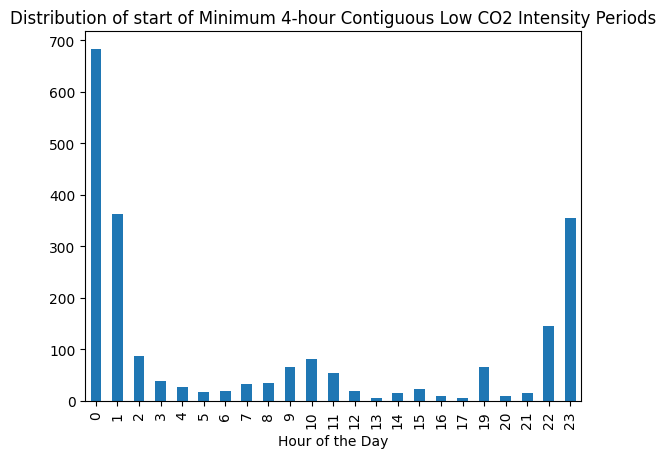

In [25]:
# df.groupby(df.period.dt.date).apply(lambda grp: _func(df=grp))
fig, ax = plt.subplots()

start_time_by_day = df.groupby(df.local_time.dt.date).apply(lambda grp: _func(df=grp)[0].hour)
start_time_by_day.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title("Distribution of start of Minimum 4-hour Contiguous Low CO2 Intensity Periods")
ax.set_xlabel("Hour of the Day")


It looks like the minimum grid intensity happens by far the most frequently in the middle of the night, but sometimes it happens in the late morning. A forecast might be marginally helpful. 

#### Sanity check and visualization

In [26]:
sample_day = df.loc[df.local_time.dt.date.astype(str) == "2024-06-01"]

In [27]:
sample_day

,period,region,CO2 Intensity,local_time,rolling_avg_intensity
1514244,2024-06-01 04:00:00+00:00,CO2i_ISNE_D,265.097768,2024-06-01 00:00:00-04:00,276.477971
1514245,2024-06-01 05:00:00+00:00,CO2i_ISNE_D,251.266000,2024-06-01 01:00:00-04:00,267.258029
1514246,2024-06-01 06:00:00+00:00,CO2i_ISNE_D,238.440043,2024-06-01 02:00:00-04:00,256.842711
1514247,2024-06-01 07:00:00+00:00,CO2i_ISNE_D,232.183765,2024-06-01 03:00:00-04:00,246.746894
1514248,2024-06-01 08:00:00+00:00,CO2i_ISNE_D,229.336986,2024-06-01 04:00:00-04:00,237.806698
1514249,2024-06-01 09:00:00+00:00,CO2i_ISNE_D,224.062074,2024-06-01 05:00:00-04:00,231.005717
1514250,2024-06-01 10:00:00+00:00,CO2i_ISNE_D,219.388726,2024-06-01 06:00:00-04:00,226.242888
1514251,2024-06-01 11:00:00+00:00,CO2i_ISNE_D,216.242176,2024-06-01 07:00:00-04:00,222.257490
1514252,2024-06-01 12:00:00+00:00,CO2i_ISNE_D,210.125481,2024-06-01 08:00:00-04:00,217.454614
1514253,2024-06-01 13:00:00+00:00,CO2i_ISNE_D,203.572875,2024-06-01 09:00:00-04:00,212.332314


In [28]:
_func(df=sample_day)

(Timestamp('2024-06-01 06:00:00-0400', tz='America/New_York'),
 Timestamp('2024-06-01 10:00:00-0400', tz='America/New_York'))

In [29]:
(min_start, min_end) = find_minimum_hour(sample_day, 'rolling_avg_intensity', 'local_time', 4)

print(f"The minimum 4-hour CO2 intensity period started at {min_start.hour}:00 and ended at {min_end.hour}:00")

The minimum 4-hour CO2 intensity period started at 6:00 and ended at 10:00


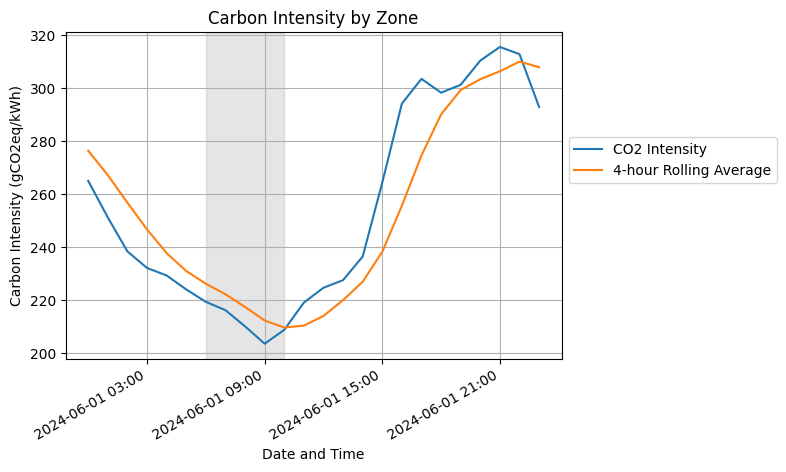

In [30]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()

ax.plot(sample_day['local_time'], sample_day['CO2 Intensity'], label="CO2 Intensity")

ax.plot(sample_day['local_time'], sample_day['rolling_avg_intensity'], label="4-hour Rolling Average")


# Add the shaded region directly using the localized timestamps
ax.axvspan(min_start, min_end, color='gray', alpha=0.2)
# ax.axvline(noon, color='red', linestyle='--')

# Set major locator to every hour
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6, tz="America/New_York"))

# Set major formatter to show date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M', tz="America/New_York"))

# Optional: rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# Optional: add grid for better readability
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 0.7))
ax.set_title("Carbon Intensity by Zone")
ax.set_ylabel("Carbon Intensity (gCO2eq/kWh)")
ax.set_xlabel("Date and Time")
fig.autofmt_xdate()
plt.show()

## Evaluate forecasting algorithms

Evaluate a minimum of two modeling algorithms using [time-series cross-validation](https://otexts.com/fpp3/tscv.html) and MAPE.

In [38]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, SeasonalNaive

In [34]:
df.columns

Index(['period', 'region', 'CO2 Intensity', 'local_time',
       'rolling_avg_intensity'],
      dtype='object')

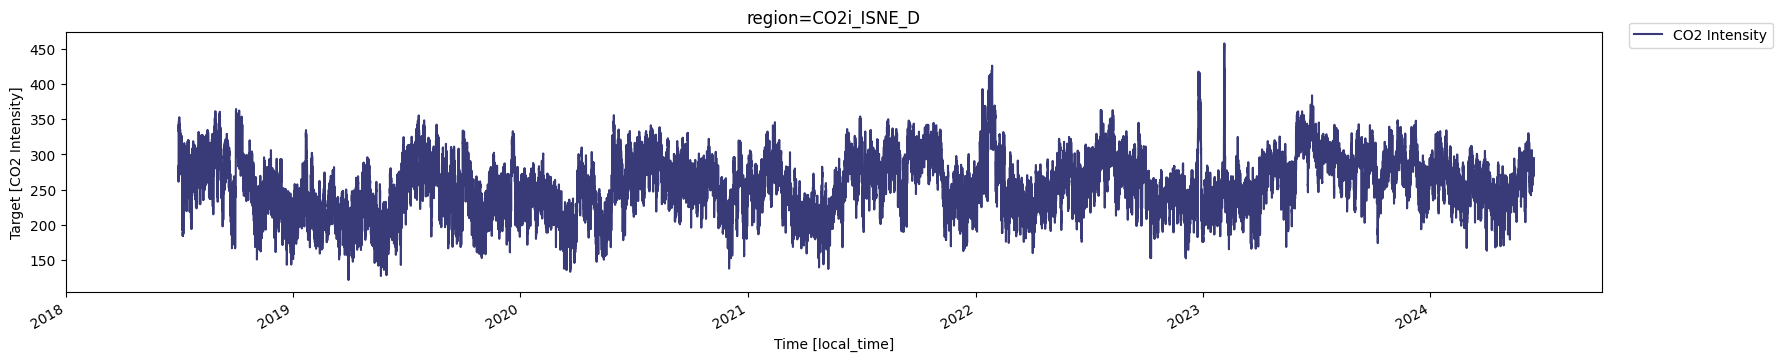

In [37]:
StatsForecast.plot(df, target_col='CO2 Intensity', time_col='local_time', id_col='region')


Define candidate model algorithms.

In [39]:
mstl = MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA() # model used to forecast trend
)

seasonal_naive = SeasonalNaive(season_length=24)

In [42]:
sf = StatsForecast(
    models=[mstl, seasonal_naive],
    freq='H', # hourly frequency
)

In [46]:
df.loc[df.local_time.dt.year == 2023].shape

(8760, 5)

Fit 12 models and evaluate with a 24 hour forecast taken ~30 days apart.

In [49]:
df.tail()

,period,region,CO2 Intensity,local_time,rolling_avg_intensity
1514578,2024-06-15 02:00:00+00:00,CO2i_ISNE_D,290.016321,2024-06-14 22:00:00-04:00,293.016744
1514579,2024-06-15 03:00:00+00:00,CO2i_ISNE_D,283.324206,2024-06-14 23:00:00-04:00,290.710500
1514580,2024-06-15 04:00:00+00:00,CO2i_ISNE_D,291.796152,2024-06-15 00:00:00-04:00,290.044026
1514581,2024-06-15 05:00:00+00:00,CO2i_ISNE_D,285.924739,2024-06-15 01:00:00-04:00,287.765355
1514582,2024-06-15 06:00:00+00:00,CO2i_ISNE_D,277.681349,2024-06-15 02:00:00-04:00,284.681612


In [52]:
_df = df[["region", "local_time", "CO2 Intensity"]].copy()
_df.columns = ["unique_id", "ds", "y"]

crossvalidation_df = sf.cross_validation(
    df = _df,
    h = 24,
    step_size = 24*30,
    n_windows = 12,
    # id_col='region',
    # target_col='CO2 Intensity',
    # time_col='local_time',
  )

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [54]:
from datasetsforecast.losses import rmse, mape

crossvalidation_df.head()

for model in ["MSTL", "SeasonalNaive"]:
    rmse_val = rmse(crossvalidation_df['y'], crossvalidation_df[model])
    mape_val = mape(crossvalidation_df['y'], crossvalidation_df[model])
    print(f"RMSE for {model}: {rmse_val}")
    print(f"MAPE for {model}: {mape_val}")





RMSE for MSTL: 16.749845504760742
MAPE for MSTL: 4.680657386779785
RMSE for SeasonalNaive: 27.554412841796875
MAPE for SeasonalNaive: 7.1020640432834625


In [ ]:
# Do we really need years of history?  I'm realizing we need recent history to use these forecasting methods
# for inference, and I only have 5 days of history at the moment.  Can we do well with five days of history?
# Let's try it out.


The MSTL model outperforms the SeasonalNaive model, so we'll use that.

## Fit the selected model class on all available history

In [66]:
#Keep one week of data for test and sanity check
df_test = _df.tail(24)
df_train = _df.drop(df_test.index)

In [67]:
sf_final =  StatsForecast(
    models=[mstl], # add SeasonalNaive model to the list
    freq='H'
)

In [68]:
df_train.head()

,unique_id,ds,y
1462356,CO2i_ISNE_D,2018-07-01 00:00:00-04:00,282.989417
1462357,CO2i_ISNE_D,2018-07-01 01:00:00-04:00,273.393594
1462358,CO2i_ISNE_D,2018-07-01 02:00:00-04:00,274.670704
1462359,CO2i_ISNE_D,2018-07-01 03:00:00-04:00,273.813093
1462360,CO2i_ISNE_D,2018-07-01 04:00:00-04:00,269.970188


In [69]:
init = time()
sf = sf_final.fit(df=df_train)
forecasts_test = sf.predict(h=len(df_test), level=[90])
end = time()
forecasts_test.head()

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:438: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,MSTL,MSTL-lo-90,MSTL-hi-90
unique_id,,,,
CO2i_ISNE_D,2024-06-14 03:00:00-04:00,276.734436,269.058258,284.410583
CO2i_ISNE_D,2024-06-14 04:00:00-04:00,276.747040,265.194641,288.299469
CO2i_ISNE_D,2024-06-14 05:00:00-04:00,274.100677,259.805145,288.396210
CO2i_ISNE_D,2024-06-14 06:00:00-04:00,277.670898,261.216980,294.124786
CO2i_ISNE_D,2024-06-14 07:00:00-04:00,271.367004,253.113083,289.620972


In [70]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(24 * 14)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
    colors = ['orange', 'green', 'red']
    for model, color in zip(models, colors):
        ax.fill_between(df_plot.index,
                        df_plot[f'{model}-lo-90'],
                        df_plot[f'{model}-hi-90'],
                        alpha=.35,
                        color=color,
                        label=f'{model}-level-90')
    ax.set_title('Grid Intensity Hourly', fontsize=22)
    ax.set_ylabel('Grid Intensity (gCO2e/kWh)', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

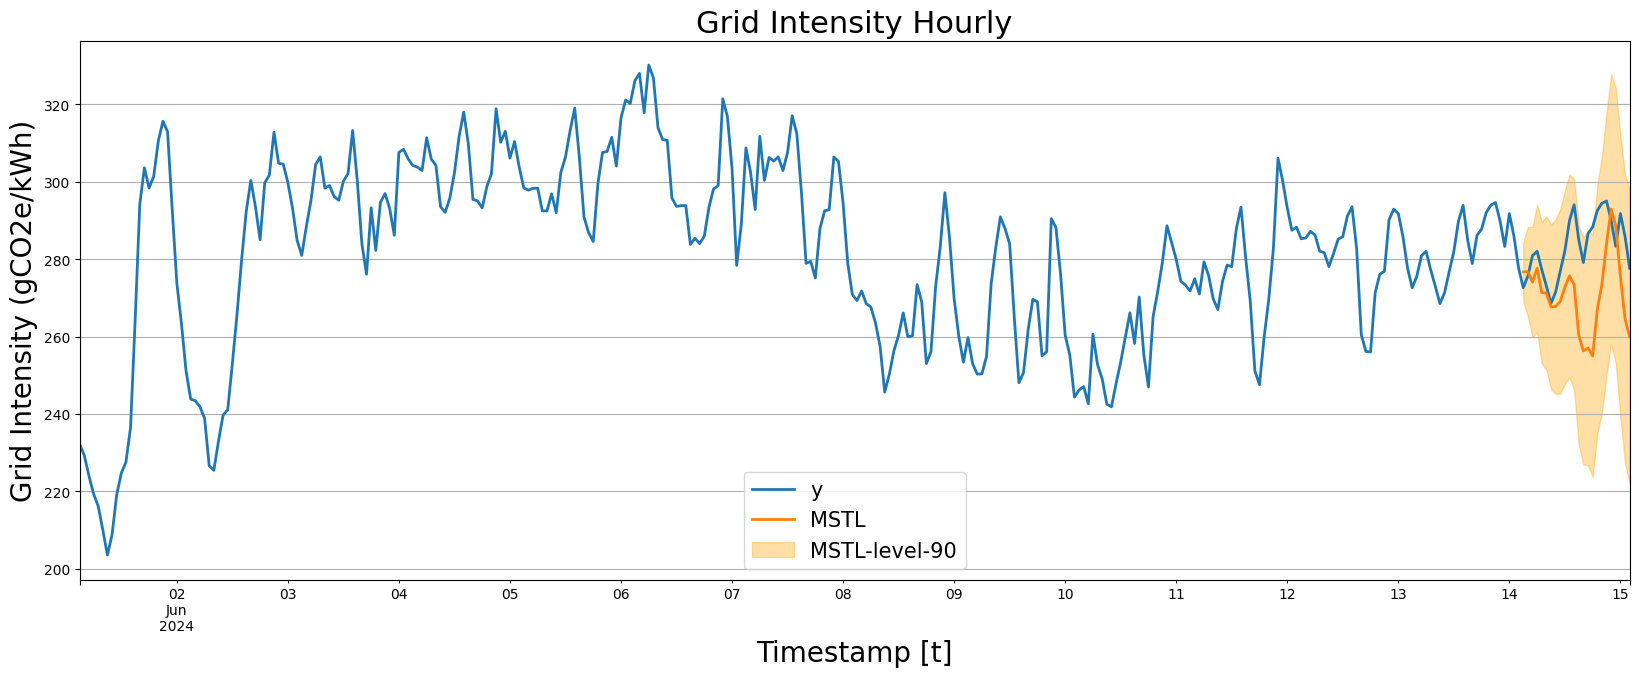

In [71]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL'])

## Fit an ML model capable of transfer forecasting

In [87]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
import lightgbm as lgb
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [79]:
_df.head()

,unique_id,ds,y
1462356,CO2i_ISNE_D,2018-07-01 00:00:00-04:00,282.989417
1462357,CO2i_ISNE_D,2018-07-01 01:00:00-04:00,273.393594
1462358,CO2i_ISNE_D,2018-07-01 02:00:00-04:00,274.670704
1462359,CO2i_ISNE_D,2018-07-01 03:00:00-04:00,273.813093
1462360,CO2i_ISNE_D,2018-07-01 04:00:00-04:00,269.970188


In [80]:
def plot_differences(df, differences):
    prep = [df]
    # Plot individual Differences
    for d in differences:
        fcst = MLForecast(
        models=[],  # we're not interested in modeling yet
        freq='H',  # our series have hourly frequency
        target_transforms=[Differences([d])],
        )
        df_ = fcst.preprocess(df)
        df_['unique_id'] = df_['unique_id'] + f'_{d}'
        prep.append(df_)

    # Plot combined Differences
    fcst = MLForecast(
        models=[],  # we're not interested in modeling yet
        freq='H',  # our series have hourly frequency
        target_transforms=[Differences([24, 24*7])],
    )
    df_ = fcst.preprocess(df)
    df_['unique_id'] = df_['unique_id'] + f'_all_diff'
    prep.append(df_)
    prep = pd.concat(prep, ignore_index=True)
    return prep

prep = plot_differences(_df, [24, 24*7])


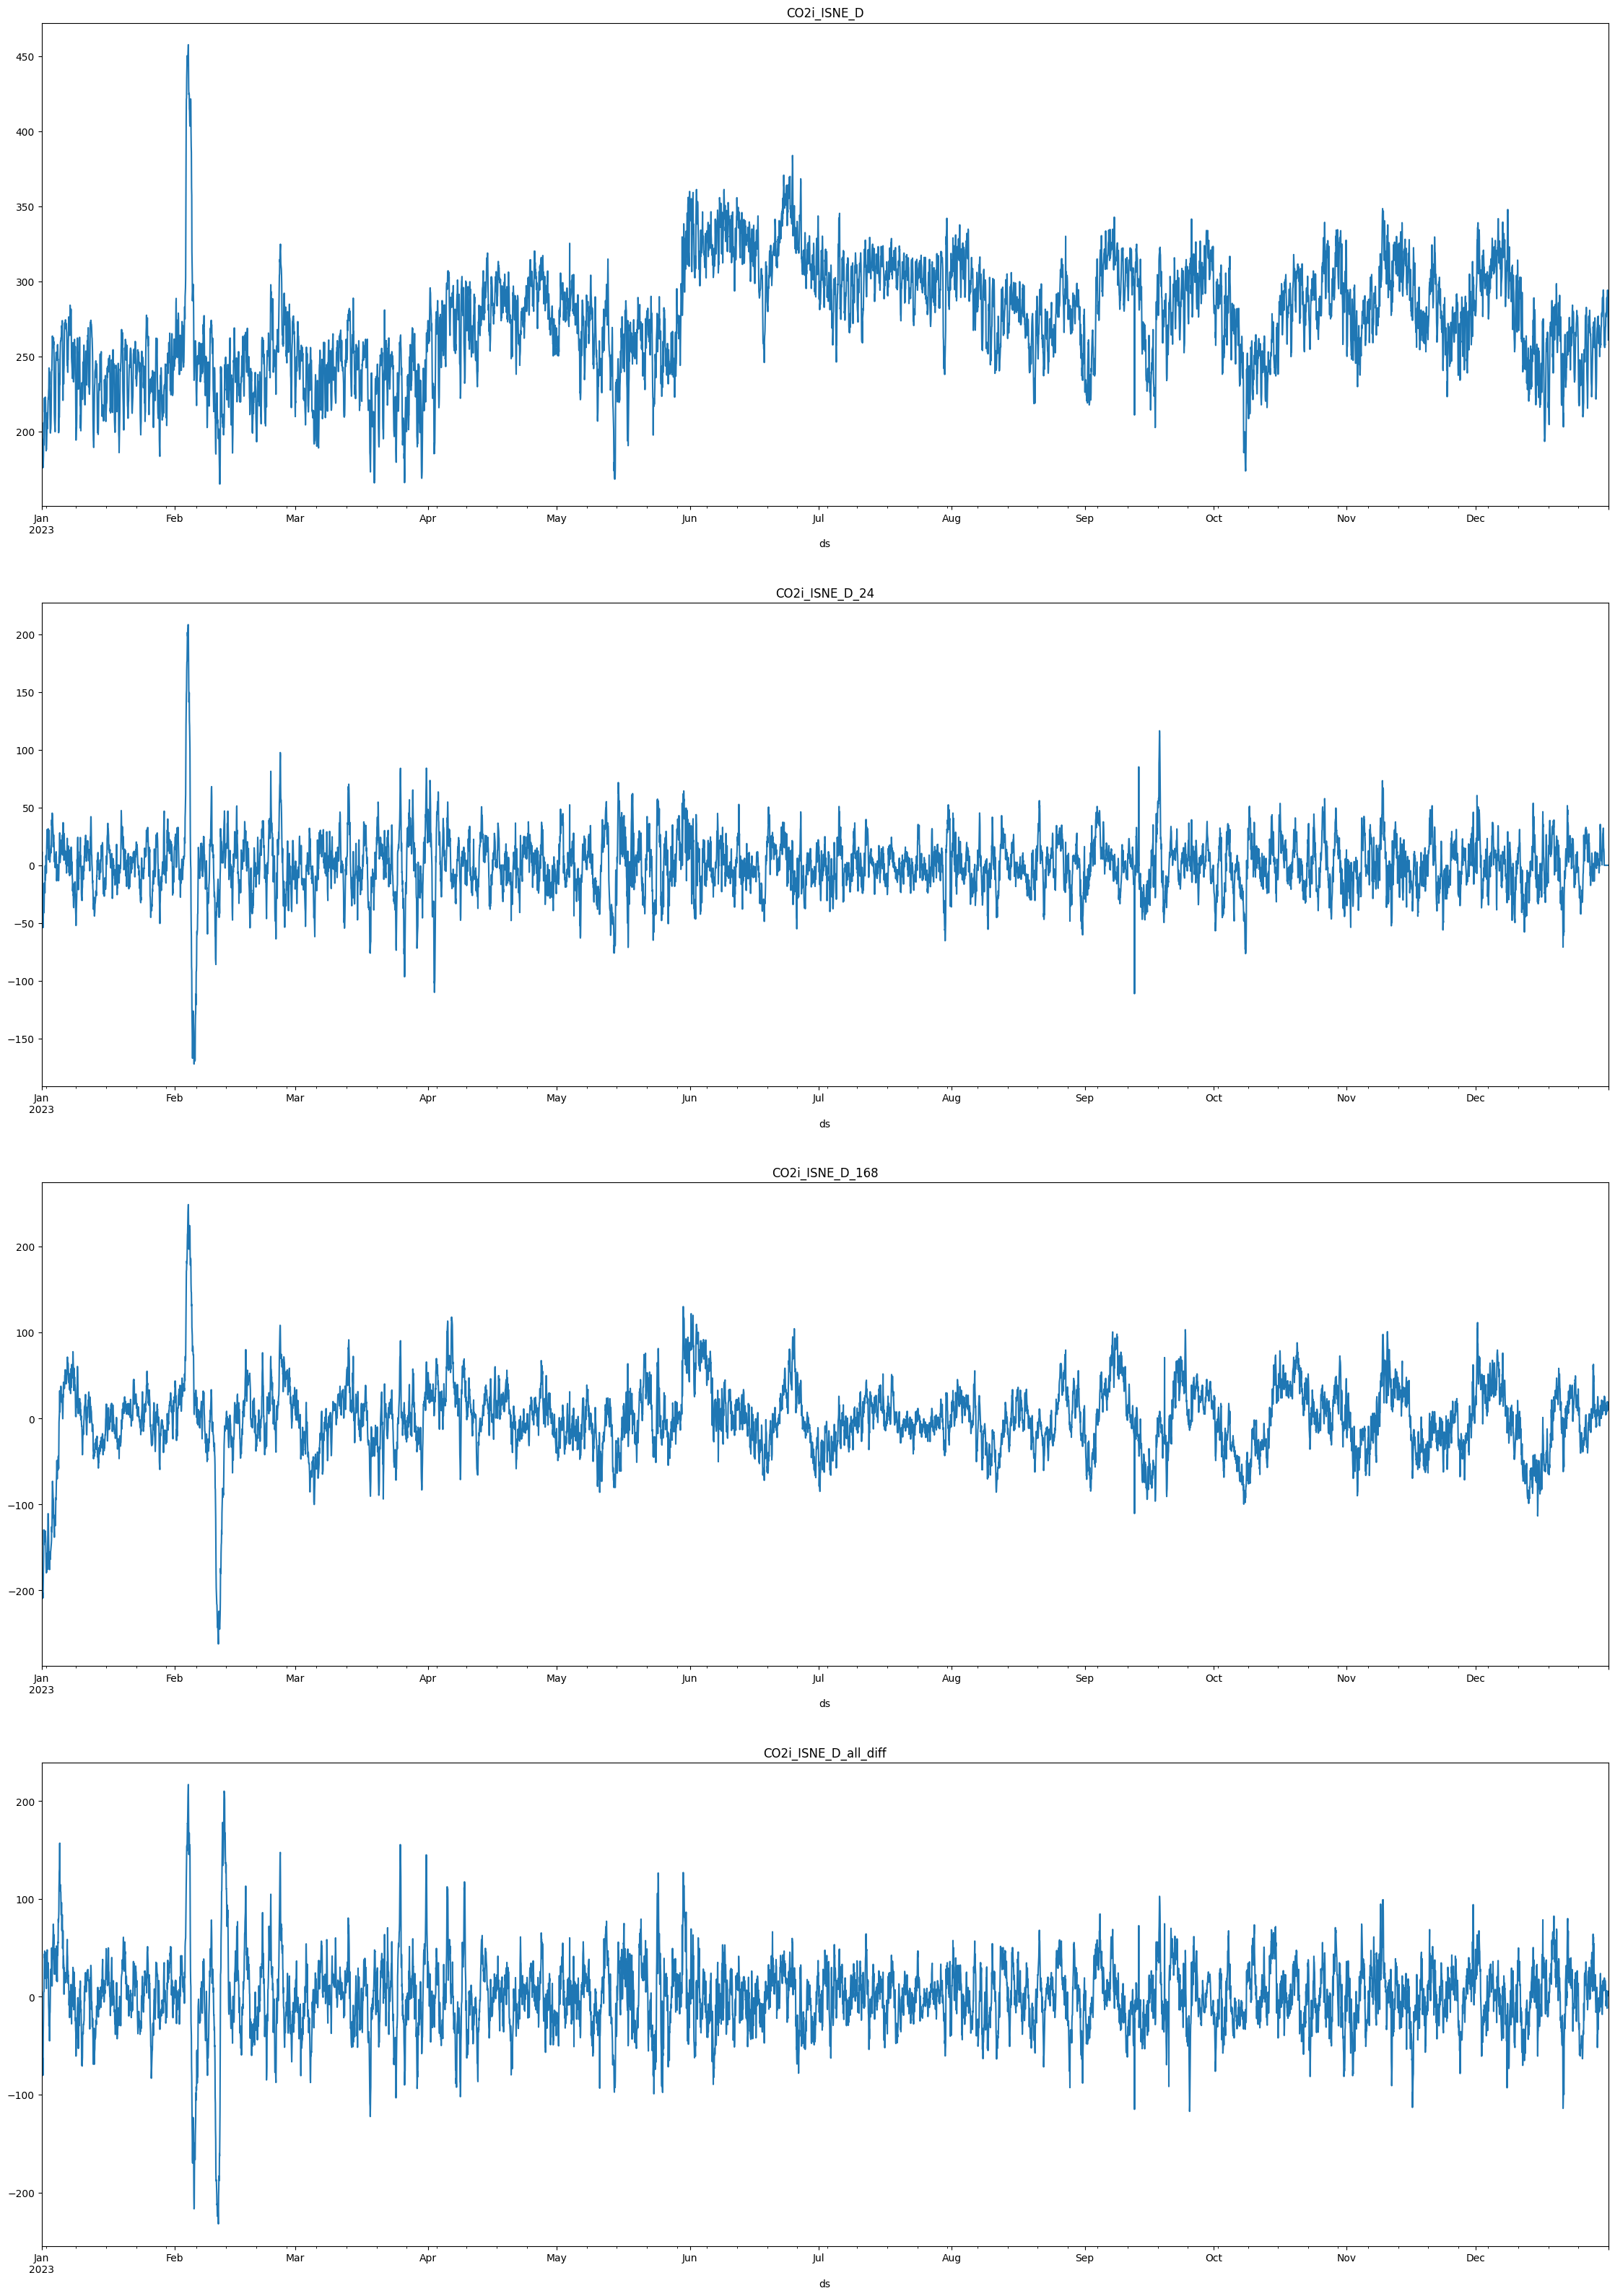

In [82]:
n_series = len(prep['unique_id'].unique())
fig, ax = plt.subplots(nrows=n_series, figsize=(7 * n_series, 10*n_series), squeeze=False)
for title, axi in zip(prep['unique_id'].unique(), ax.flat):
    df_ = prep[(prep['unique_id'] == title) & (prep['ds'].dt.year == 2023)]
    df_.set_index('ds')['y'].plot(title=title, ax=axi)

plt.show()


Create a benchmark Naive model that uses the level last hour as the prediction in the next timestep. This is not the same 

In [84]:
from sklearn.base import BaseEstimator

class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']


In [86]:
models = {
    "naive": Naive(),
    "lgbm": lgb.LGBMRegressor(verbosity=-1)
}

In [89]:
mlf = MLForecast(
    models = models,
    freq='h',  # our series have hourly frequency
    target_transforms=[Differences([24, 24*7])],
    lags=[1,12,24], # Lags to be used as features
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=['month', 'hour', 'dayofweek']
)


In [107]:
features = mlf.preprocess(df_train)
features.head()

,unique_id,ds,y,lag1,lag12,lag24,expanding_mean_lag1,rolling_mean_lag24_window_size48,month,hour,dayofweek
1462619,CO2i_ISNE_D,2018-07-11 23:00:00-04:00,-18.263185,-17.757512,-0.095427,18.481661,22.838204,26.017489,7,23,2
1462620,CO2i_ISNE_D,2018-07-12 00:00:00-04:00,-23.255980,-18.263185,1.686962,28.017047,22.267352,26.782027,7,0,3
1462621,CO2i_ISNE_D,2018-07-12 01:00:00-04:00,-43.024484,-23.255980,5.659738,48.674784,21.643744,28.336406,7,1,3
1462622,CO2i_ISNE_D,2018-07-12 02:00:00-04:00,-31.464378,-43.024484,-1.193688,51.869746,20.769850,29.829695,7,2,3
1462623,CO2i_ISNE_D,2018-07-12 03:00:00-04:00,-25.484309,-31.464378,7.849141,41.584750,20.073393,31.222639,7,3,3


In [91]:
cv_df = mlf.cross_validation(
    df=df_train,
    h=24,
    n_windows=40,
    refit=False,
)

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsfo

In [92]:
cv_df.head()

,unique_id,ds,cutoff,y,naive,lgbm
0,CO2i_ISNE_D,2024-05-05 03:00:00-04:00,2024-05-05 02:00:00-04:00,218.848971,218.632112,217.531868
1,CO2i_ISNE_D,2024-05-05 04:00:00-04:00,2024-05-05 02:00:00-04:00,217.418463,213.619318,210.031523
2,CO2i_ISNE_D,2024-05-05 05:00:00-04:00,2024-05-05 02:00:00-04:00,211.847398,213.778380,209.522185
3,CO2i_ISNE_D,2024-05-05 06:00:00-04:00,2024-05-05 02:00:00-04:00,215.179475,211.827681,208.680653
4,CO2i_ISNE_D,2024-05-05 07:00:00-04:00,2024-05-05 02:00:00-04:00,222.892294,207.664480,205.329904


In [93]:
for model in ["naive", "lgbm"]:
    rmse_val = rmse(cv_df['y'], cv_df[model])
    mape_val = mape(cv_df['y'], cv_df[model])
    print(f"RMSE for {model}: {rmse_val}")
    print(f"MAPE for {model}: {mape_val}")

RMSE for naive: 28.1915120963086
MAPE for naive: 8.09258161560071
RMSE for lgbm: 23.795806194921553
MAPE for lgbm: 6.965006149816793


In [103]:
def plot_cv(df, df_cv, uid, cutoffs=None, last_n=24 * 14, models={}, ax=None):
    if cutoffs is None:
        cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    if ax is None:
        fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(14, 14), gridspec_kw=dict(hspace=0.8))
    else:
        fig = ax[0].get_figure()
    for cutoff, axi in zip(cutoffs, ax.flat):
        print(f"Plotting {uid} for cutoff {cutoff}")
        max_date = df_cv.query('unique_id == @uid & cutoff == @cutoff')['ds'].max()
        df[df['ds'] < max_date].query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        for m in models.keys():
            df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y=m)

    return fig, ax



Plotting CO2i_ISNE_D for cutoff 2024-06-06 02:00:00-04:00
Plotting CO2i_ISNE_D for cutoff 2024-06-11 02:00:00-04:00
Plotting CO2i_ISNE_D for cutoff 2024-06-05 02:00:00-04:00
Plotting CO2i_ISNE_D for cutoff 2024-05-07 02:00:00-04:00
Plotting CO2i_ISNE_D for cutoff 2024-06-08 02:00:00-04:00


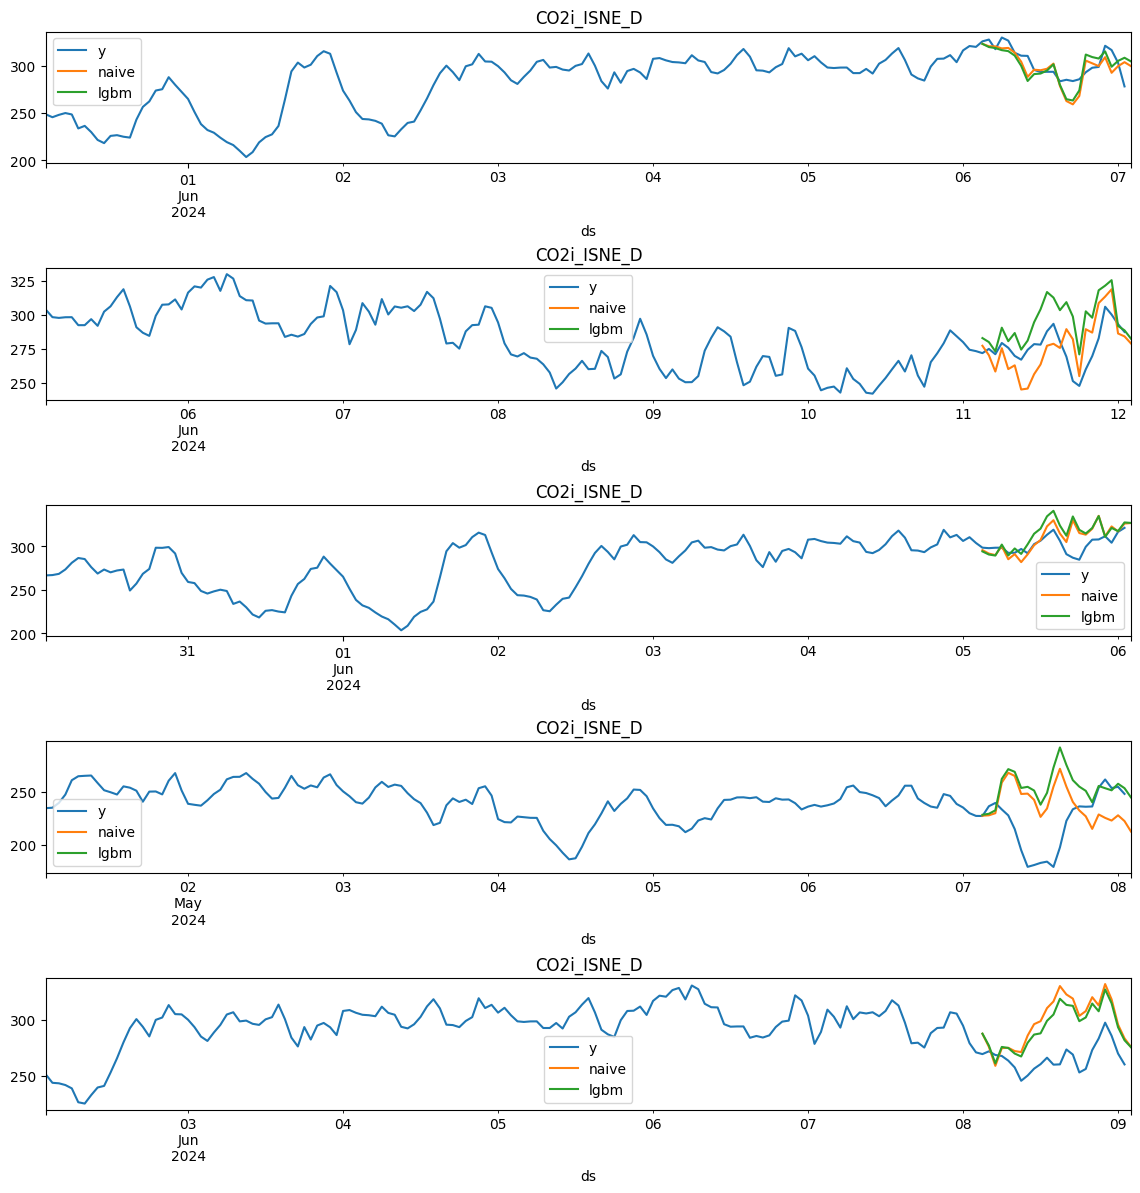

In [106]:

cutoffs = list(pd.Series(cv_df['cutoff'].unique()).sample(5))
fig, ax = plot_cv(df_train, cv_df, "CO2i_ISNE_D", cutoffs, last_n=24*7, models=models)
plt.show()

In [101]:
cutoffs

35   2024-06-09 02:00:00-04:00
15   2024-05-20 02:00:00-04:00
0    2024-05-05 02:00:00-04:00
17   2024-05-22 02:00:00-04:00
1    2024-05-06 02:00:00-04:00
dtype: datetime64[ns, America/New_York]

## Save the final model and use for forecasting

In [72]:
sf_final.save("../models/final_model.pkl")

Saving StatsForecast object of size 4.34MB.
StatsForecast object saved
